In [198]:
cd ..

/lustre/home/ucapmm6/src_aiai


In [1]:
import tensorflow as tf

In [2]:
import numpy as np

In [3]:
import tqdm

In [4]:
import matplotlib.pyplot as plt

In [5]:
from src.sampling.uv_sampling import spider_sampling

In [351]:
from scipy.special import iv, jv

In [7]:
from scipy.sparse import *

In [12]:
import sparse

In [13]:
uv = spider_sampling()

In [14]:
Kd = (512, 512)

In [15]:
gridsize = 2*np.pi / Kd[0]
k = (uv + np.pi) / gridsize
kx = (uv[:,0] + np.pi) // gridsize
ky = (uv[:,1] + np.pi) // gridsize

In [1148]:
def calculate_coef(k, i, Jd=(6,6)):
    
    J = Jd[0]//2
    a = np.array(np.meshgrid(range(-J, J+1), range(-J, J+1))).reshape(2, -1)
    indices = (k.astype(int).reshape(-1,1) + a)
#     print(indices)

    J = np.linalg.norm(Jd) #composite J
#     J = Jd[0]

    beta = 2.34*J
    norm = iv(0, beta)

    u = np.linalg.norm(k.reshape(2,1) - indices, axis=0)
    values = iv(0, beta*np.sqrt(1 +0j - (4*u/Jd[0])**2)).real / norm # 4J because composite J = 
    
#     K = 512
#     N = 256
#     gam = 2 * np.pi / K
#     phase_scale = 1j * gam * (N - 1) / 2

#     phase = np.exp(phase_scale * indices)
# #     values = values*phase

#     u = k.reshape(2,1) - indices
#     values = np.ones(u.shape[1], dtype=complex)
#     for i in range(u.shape[0]):
#         values *= (iv(0, beta*np.sqrt(1 +0j - (2*u[i]/Jd[0])**2)) / norm).real * phase[i]

    indices = np.vstack((np.zeros(indices.shape[1]), np.repeat(i, indices.shape[1]), indices[0], indices[1])).astype(int)

    return indices.T, values

In [1149]:

gridsize = 2*np.pi / Kd[0]
k = (uv + np.pi) / gridsize

In [1150]:
ind, vals = calculate_coef(k[0], 0, (6,6))


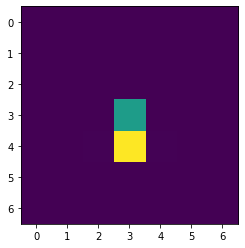

In [1151]:
plt.imshow(vals.reshape(7,7).real)

In [1039]:
def kaiser_bessel_ft(om, npts, alpha, order, d):
    """Computes FT of KB function for scaling in image domain.
    Args:
        om (ndarray): An array of coordinates to interpolate to.
        npts (int): Number of points to use for interpolation in each
            dimension.
        order (int): Order of Kaiser-Bessel kernel.
        alpha (double or array of doubles): KB parameter.
        d (int):  ## TODO: find what d is
    Returns:
        ndarray: The scaling coefficients.
    """
    z = np.sqrt((2 * np.pi * (npts / 2) * om)**2 - alpha**2 + 0j)
    nu = d / 2 + order
    scaling_coef = (2 * np.pi)**(d / 2) * ((npts / 2)**d) * (alpha**order) / \
        iv(order, alpha) * jv(nu, z) / (z**nu)
    scaling_coef = np.real(scaling_coef)

    return scaling_coef


def compute_scaling_coefs(im_size, grid_size, numpoints, alpha, order):
    """Computes scaling coefficients for NUFFT operation.
    Args:
        im_size (tuple): Size of base image.
        grid_size (tuple): Size of the grid to interpolate from.
        numpoints (tuple): Number of points to use for interpolation in each
            dimension. Default is six points in each direction.
        alpha (tuple): KB parameter.
        order (tuple): Order of Kaiser-Bessel kernel.
    Returns:
        ndarray: The scaling coefficients.
    """
    num_coefs = np.array(range(im_size[0])) - (im_size[0] - 1) / 2
    scaling_coef = 1 / kaiser_bessel_ft(
        num_coefs / grid_size[0],
        numpoints[0],
        alpha[0],
        order[0],
        1
    )
    if numpoints[0] == 1:
        scaling_coef = np.ones(scaling_coef.shape)
    for i in range(1, len(im_size)):
        indlist = np.array(range(im_size[i])) - (im_size[i] - 1) / 2
        scaling_coef = np.expand_dims(scaling_coef, axis=-1)
        tmp = 1 / kaiser_bessel_ft(
            indlist / grid_size[i],
            numpoints[i],
            alpha[i],
            order[i],
            1
        )

        for _ in range(i):
            tmp = tmp[np.newaxis]

        if numpoints[i] == 1:
            tmp = np.ones(tmp.shape)

        scaling_coef = scaling_coef * tmp

    return scaling_coef

In [1040]:
s = compute_scaling_coefs((256,256), (512,512), (6,6), (2.34*6, 2.34*6), (0,0))

In [1041]:
np.allclose(s, op.scaling)

True

In [1232]:
class Op():
    def __init__(self):
        pass
    
    def plan(self, uv, Nd, Kd, Jd):
        # saving some values
        self.Nd = Nd
        self.Kd = Kd
        self.Jd = Jd
        self.M = len(uv)
        
        gridsize = 2*np.pi / Kd[0]
        k = (uv + np.pi) / gridsize
        
        # calculating coefficients for interpolation
        indices = []
        values =  []
        for i in tqdm.tqdm(range(len(uv))):
            ind, vals = calculate_coef(k[i], i, Jd)
            indices.append(ind)
            values.append(vals.real)
        
        indices = np.array(indices).reshape(-1, 4)
        values = np.array(values).reshape(-1)
        self.interp_matrix = sparse.COO(indices.T, values, shape=(1, len(uv), Kd[0], Kd[1]))
    
        # calculating correcting scaling
        xx, yy = np.mgrid[:Nd[0], :Nd[1]]
        xx = (xx - Nd[0]/2) #/Nd[0]
        yy = (yy - Nd[1]/2) #/Nd[1]
    
        xx = np.linspace(128,384,Nd[0]) /Kd[0] -.5 # (i/K - 1/2)
        yy = np.linspace(128,384,Nd[0]) /Kd[0] -.5
    
#         xx = yy = (np.linspace(-0.5,0.5, Nd[0])) * Nd[0]/Kd[0]
    
    
        beta = 2.34*Jd[0]
#         x_ =  np.sqrt((xx-Nd[0]/2)**2 + (yy-Nd[0]/2)**2) # TODO Nd[0]/2 or //2, also 2d?
#         y_scale =  np.sqrt((xx-Nd[0]/2)**2 + (yy-Nd[0]/2)**2) # TODO Nd[0]/2 or //2, also 2d?
        
#         du = np.linspace(-.25,.25, Nd[0]) *2
        z1 = np.sqrt(np.pi**2 * (xx)**2 * Jd[0]**2 - beta**2 + 0j)
        z2 = np.sqrt(np.pi**2 * (yy)**2 * Jd[0]**2 - beta**2 + 0j)
        
        norm = Jd[0] / iv(0, beta)
        self.x_scale = np.sin(z1)/z1 *norm
        self.y_scale = np.sin(z2)/z2 *norm
        
#         print(np.sin(z1)/z1)
#         return
        d=1
        nu = d / 2 + 0
        order = 0
        J = Jd[0]
        
        scaling_coef1 = (2 * np.pi)**(d / 2) * ((J / 2)**d) * (beta**order) / \
            iv(order, beta) * jv(nu, z1) / (z1**nu)
        self.scaling_coef1 = np.real(scaling_coef1)
    
        scaling_coef2 = (2 * np.pi)**(d / 2) * ((J / 2)**d) * (beta**order) / \
            iv(order, beta) * jv(nu, z2) / (z2**nu)
        self.scaling_coef2 = np.real(scaling_coef2)
    
#         self.scaling = 1/(self.x_scale * self.y_scale).real
        self.scaling = 1/(self.x_scale.reshape(-1,1) * self.y_scale.reshape(1,-1)).real
#         self.scaling =  1/(self.scaling_coef2.reshape(-1,1) * self.scaling_coef1.reshape(1,-1)).real.T
#         self.scaling = compute_scaling_coefs((256,256), (512,512), (6,6), (2.34*6, 2.34*6), (0,0))
#         self.scaling = (jv(1/2, z)/iv(0,z)) #/(x_scale*y_scale)
#         self.scaling = self.scaling * self.scaling.T
        
    def forward(self, xx):
        return np.squeeze(self._kk2k(self._xx2kk(self._pad((xx*self.scaling).reshape(-1, self.Nd[0], self.Nd[1]))))) 
#         return np.squeeze(self._kk2k(self._xx2kk(self._pad((xx).reshape(-1, self.Nd[0], self.Nd[1]))*self.scaling))) 
    
    def adjoint(self, k):
        return np.squeeze(self._unpad(self._kk2xx(self._k2kk(k)))) / self.scaling
    
    def _kk2k(self, kk):
        """interpolates of the grid to non uniform measurements"""
        return (self.interp_matrix * kk.reshape(-1, 1, self.Kd[0], self.Kd[1])).sum(axis=(2,3)).todense()
    
    def _k2kk(self, y):
        """convolutes measurements to oversampled fft grid"""
        return (self.interp_matrix * y.reshape(-1, self.M, 1, 1)).sum(axis=1).todense()
    
    @staticmethod
    def _kk2xx(kk):
        """from 2d fourier space to 2d image space"""
        return np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(kk, axes=(-2,-1)), axes=(-2,-1), norm='ortho'), axes=(-2,-1))

    @staticmethod
    def _xx2kk(xx):
        """from 2d fourier space to 2d image space"""
        return np.fft.fftshift(np.fft.fft2(np.fft.fftshift(xx, axes=(-2,-1)), axes=(-2,-1), norm='ortho'), axes=(-2,-1))
    
    def _pad(self, x):
        """pads x to go from Nd to Kd"""
        return np.pad(x, (
            ( 0,0 ),
            ( (self.Kd[0]-self.Nd[0])//2, (self.Kd[0]-self.Nd[0])//2),
            ( (self.Kd[1]-self.Nd[1])//2, (self.Kd[1]-self.Nd[1])//2)
            ))
    
    
    def _unpad(self, x):
        """unpads x to go from  Kd to Nd"""
        return x[
            :,
            (self.Kd[0]-self.Nd[0])//2: (self.Kd[0]-self.Nd[0])//2 +self.Nd[0],
            (self.Kd[1]-self.Nd[1])//2: (self.Kd[1]-self.Nd[1])//2 +self.Nd[1]
            ] # remove zero padding from image

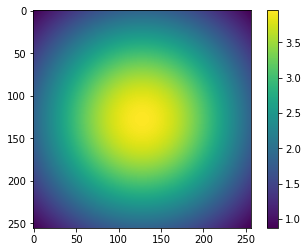

In [1233]:
plt.imshow((op.y_scale.reshape(-1,1) * op.x_scale.reshape(1,-1)).real)
plt.colorbar()

In [1234]:
iv(0, 2.34*6)

134504.519148595

In [1235]:
op = Op()

In [1236]:
%%time
op.plan(uv, Nd=(256,256), Kd=(512,512), Jd=(6,6))

100%|██████████| 4440/4440 [00:01<00:00, 4160.65it/s]

CPU times: user 1.11 s, sys: 4.64 ms, total: 1.11 s
Wall time: 1.1 s


In [1237]:
op.scaling.shape

(256, 256)

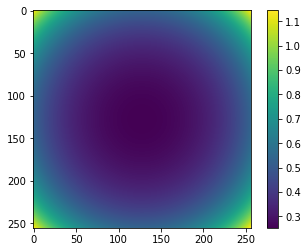

In [1238]:
plt.imshow(op.scaling)
plt.colorbar()

In [1239]:
# x = load_M51()
x = np.ones((256,256))

In [1240]:
%%time
y = op.forward(x)

CPU times: user 48.2 ms, sys: 9.89 ms, total: 58.1 ms
Wall time: 53.5 ms


In [1241]:
%%time
x_dirty = op.adjoint(np.ones_like(y))

CPU times: user 83.1 ms, sys: 0 ns, total: 83.1 ms
Wall time: 82.3 ms


In [1242]:
y2 = m_op.dir_op(x)
x_d2 = m_op.adj_op(np.ones_like(y))

y2

array([ 4.72936851e+03+1.61560077e+02j,  8.03691095e+03+2.52121591e+02j,
        8.01746210e+03+2.32518397e+02j, ...,
        7.54195569e+00+3.14755200e+00j,  9.59160464e+00+3.77357700e+00j,
       -1.18180390e-01-4.39870013e-02j])

In [1243]:
y

array([ 1.99840939e+00+5.73350334e-02j,  1.04469262e+01+3.20360559e-01j,
        8.23247889e+00+2.50948027e-01j, ...,
        1.75840417e-03+7.26113840e-04j,  2.53261178e-03+9.75005473e-04j,
       -1.64309321e-04-6.17961024e-05j])

In [1244]:
np.mean(y/y2).real, np.std(y/y2).real

(0.0011933864447065481, 0.03172318340624501)

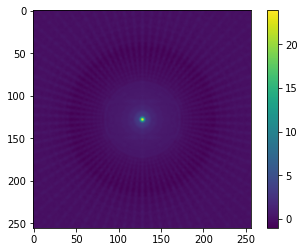

In [1245]:
plt.imshow(x_dirty.real)
plt.colorbar()

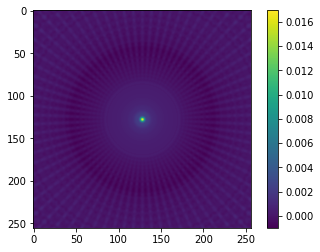

In [1247]:
plt.imshow(x_d2.real)
plt.colorbar()

In [1221]:
np.linalg.norm(x_dirty)

99.55041371704581

In [1222]:
np.linalg.norm(x_d2)

296.0283

In [1223]:
op.scaling

array([[0.87398202, 0.88463929, 0.89533133, ..., 0.89533133, 0.88463929,
        0.87398202],
       [0.88463929, 0.89542652, 0.90624893, ..., 0.90624893, 0.89542652,
        0.88463929],
       [0.89533133, 0.90624893, 0.91720215, ..., 0.91720215, 0.90624893,
        0.89533133],
       ...,
       [0.89533133, 0.90624893, 0.91720215, ..., 0.91720215, 0.90624893,
        0.89533133],
       [0.88463929, 0.89542652, 0.90624893, ..., 0.90624893, 0.89542652,
        0.88463929],
       [0.87398202, 0.88463929, 0.89533133, ..., 0.89533133, 0.88463929,
        0.87398202]])

In [1224]:
m = np.median(x_d2.real/ x_dirty.real)
m, np.median(np.abs(x_d2.real/ x_dirty.real-m))



(2.7999112107474353, 0.35857198233907495)

/lustre/home/ucapmm6/src_aiai/env/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


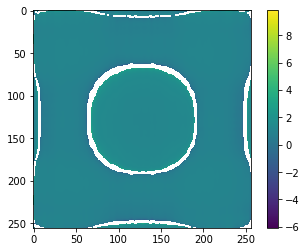

In [1225]:
plt.imshow(np.log(x_d2.real/ x_dirty.real))
plt.colorbar()

In [115]:
kernels = []

indices = []
values =  []
for i in tqdm.tqdm(range(len(uv))):
    
#     k = (int(kx[i]), int(ky[i]))
    
    ind, vals = calculate_coef(k[i], i)
    
#     M = tf.sparse.SparseTensor(ind, values, Kd)
#     M = tf.sparse.expand_dims(M, axis=0) 
#     M = csr_matrix(( values.real, (ind[:,0], ind[:,1])), shape=(512,512))
    
#     kernels.append(M)

    indices.append(ind)
    values.append(vals.real)


#     if i ==0:
# #         break
#         Matrix = M
# #         Matrix = M
#     else:
#         Matrix = vstack([M])
#         pass
# #         Matrix = tf.sparse.concat(0, [Matrix, M])
    

100%|██████████| 4440/4440 [00:01<00:00, 4003.25it/s]


In [116]:
indices = np.array(indices).reshape(-1, 4)
values = np.array(values).reshape(-1)

In [68]:
i=0
ind, values = calculate_coef(k[i], i)

In [80]:
indices.shape, values.shape

((159840, 3), (159840,))

In [49]:
indices = np.vstack((np.zeros(len(ind)), ind[:,0], ind[:,1])).astype(int)

In [136]:
N=100
m = np.ones((N,len(uv))).reshape(N,-1,1,1)

In [137]:
%%time
c = (s * m).sum(axis=1)

CPU times: user 5.76 s, sys: 2.3 s, total: 8.06 s
Wall time: 8.07 s


In [124]:
c.shape

(3, 512, 512)

/lustre/home/ucapmm6/src_aiai/env/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


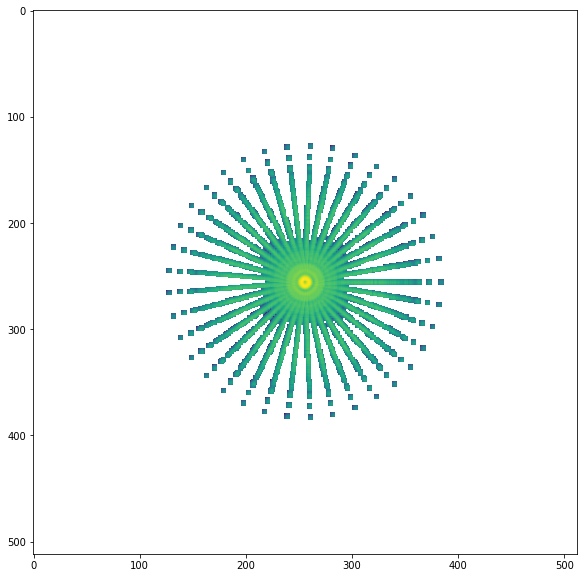

In [125]:
plt.figure(figsize=(10,10))
plt.imshow( np.log(np.abs(c.todense()[0])) ) 

In [111]:
%%time
total = csr_matrix(Kd)
measurements = np.ones(len(uv))

# for i in range(len(uv)):
total = np.sum([kernels[i]*measurements[i] for i in range(len(uv))])

CPU times: user 1.23 s, sys: 17.9 ms, total: 1.24 s
Wall time: 1.26 s


In [13]:
Matrix2 = Matrix

In [111]:
plt.figure(figsize=(10,10))
plt.imshow(np.log(total))

NameError: name 'total' is not defined

<Figure size 720x720 with 0 Axes>

In [25]:
measurements = tf.cast(tf.convert_to_tensor(np.arange(len(uv), dtype=np.complex128).reshape(-1,1,1)), tf.complex128)

In [26]:
measurements

<tf.Tensor: shape=(4440, 1, 1), dtype=complex128, numpy=
array([[[0.000e+00+0.j]],

       [[1.000e+00+0.j]],

       [[2.000e+00+0.j]],

       ...,

       [[4.437e+03+0.j]],

       [[4.438e+03+0.j]],

       [[4.439e+03+0.j]]])>

In [34]:
c = Matrix* np.arange(len(uv), dtype=np.complex128).reshape(-1,1)

NotFoundError: Could not find device for node: {{node SparseDenseCwiseMul}} = SparseDenseCwiseMul[T=DT_COMPLEX128]
All kernels registered for op SparseDenseCwiseMul:
  device='CPU'; T in [DT_DOUBLE]
  device='CPU'; T in [DT_FLOAT]
  device='CPU'; T in [DT_BFLOAT16]
  device='CPU'; T in [DT_HALF]
  device='CPU'; T in [DT_INT8]
  device='CPU'; T in [DT_UINT8]
  device='CPU'; T in [DT_INT16]
  device='CPU'; T in [DT_UINT16]
  device='CPU'; T in [DT_INT32]
  device='CPU'; T in [DT_INT64]
 [Op:SparseDenseCwiseMul]

In [27]:
%%time
c = tf.sparse.reduce_sum(Matrix*measurements, axis=0)

NotFoundError: Could not find device for node: {{node SparseDenseCwiseMul}} = SparseDenseCwiseMul[T=DT_COMPLEX128]
All kernels registered for op SparseDenseCwiseMul:
  device='CPU'; T in [DT_DOUBLE]
  device='CPU'; T in [DT_FLOAT]
  device='CPU'; T in [DT_BFLOAT16]
  device='CPU'; T in [DT_HALF]
  device='CPU'; T in [DT_INT8]
  device='CPU'; T in [DT_UINT8]
  device='CPU'; T in [DT_INT16]
  device='CPU'; T in [DT_UINT16]
  device='CPU'; T in [DT_INT32]
  device='CPU'; T in [DT_INT64]
 [Op:SparseDenseCwiseMul]

In [16]:
plt.imshow(c)

NameError: name 'c' is not defined

In [8]:
from src.operators.measurement import NUFFT_op

Failed to import NUDFT_cupy (experimental). Use NUDFT() instead. 


In [ ]:
def gradient(x, y, m_op):
    # A_t (A(x) - y)
    return m_op.adj_op( m_op.dir_op(x) - y).real

In [ ]:
def tf_function(x, y):
    uv = spider_sampling()
    m_op = NUFFT_op(uv)

   
    func = partial(gradient, y=y, m_op=m_op)

    @tf.function(input_signature=[tf.TensorSpec(None, tf.float32)])
        def tf_function(x):
            return tf.numpy_function(func, [x], (tf.float32,))

In [208]:
uv = spider_sampling()
m_op = NUFFT_op(uv)

In [196]:
from src.data import load_M51

In [197]:
x = load_M51()

FileNotFoundError: [Errno 2] No such file or directory: './data/M51.fits'

In [ ]:
y = m_op.dir_op(x)

In [207]:
from pynufft import NUFFT

class NUFFT_op():
    """Simple measurement operator using the pyNUFFT package to sample at non-uniform u,v coordinates"""
    def __init__(self, vis, Nd=(256,256), Kd=(512,512), Jd=(6,6)):
        """ Initialises the measurement operators for u,v coordinates 'vis' (M x 2)"""
        self.op = NUFFT()
        self.op.plan(vis, Nd, Kd, Jd)
        self.n_measurements = len(vis)
        
    def dir_op(self, x):
        y = self.op.forward(x) 
        return y
    
    def adj_op(self, y):
        x = self.op.adjoint(y)
        return x
    
    def self_adj(self, x):
        y = self.dir_op(x)
        x = self.adj_op(y)
        return x.real
